Author: Victor Bellón
Here we use PCA and Logistic regression with an l1 regularization and a threshold of 0.9 to set the prediction

In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score, confusion_matrix
import GPyOpt, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from GPy import kern
from paramz import Model, Param

In [2]:
class ParamzLogReg(Model):
    def __init__(self, X, y, C=1.,n_components=3, rep= 1,name='ParamzLogReg'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzLogReg, self).__init__(name=name)

        self.X = X
        self.Y = y
        
        self.C = Param('C', C)
        self.n_components = Param('n_components', n_components)
        self.link_parameters(self.C,self.n_components)
        self.sk = [(tr_idx,test_idx) for tr_idx,test_idx in StratifiedKFold(self.Y, shuffle=True) for _ in range(rep)]
        
    def parameters_changed(self):
        from sklearn.metrics import accuracy_score
    
        self._acc = 0.
    
        for train_index, test_index in self.sk:
            pca = PCA(n_components=int(self.n_components.values))
            rfc = LogisticRegression(penalty='l2', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
            x_tr = pca.fit_transform(self.X[train_index])
            x_te = pca.transform(self.X[test_index])
            rfc = rfc.fit(x_tr, self.Y[train_index])
            prediction = rfc.predict(x_te)
            self._acc += accuracy_score(self.Y[test_index], prediction)/float(len(self.sk))
            
    def objective_function(self):
        import numpy as np
        #print self._acc
        return -np.atleast_1d(self._acc)
    def predict(self, X):
        pca = PCA(n_components=int(self.n_components.values))
        rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
        x_tr = pca.fit_transform(self.X)
        x_te = pca.transform(X)
        rfc = rfc.fit(x_tr, self.Y)
        prediction = rfc.predict(x_te)
        return prediction
    def train(self):
        self.pca = PCA(n_components=int(self.n_components.values))
        self.rfc = LogisticRegression(penalty='l1', C=float(self.C.values), n_jobs=-1,class_weight='balanced')
        x_tr = self.pca.fit_transform(self.X)
        self.rfc.fit(x_tr, self.Y)

    def predict_proba(self, X):
        x_te = self.pca.transform(X)
        prediction = self.rfc.predict_proba(x_te)
        return prediction

In [3]:
def proces_data(data,design):
    train_idx = design.Set == design.Set.unique()[0]
    test_idx = ~train_idx
    train_set = data.loc[:, train_idx]
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx]
    test_set[:] = normalizer.transform(test_set.T).T
    train_labels = design.loc[train_idx, 'Effect']
    test_labels = design.loc[test_idx, 'Effect']
    return train_idx, test_idx,train_set, test_set, train_labels, test_labels

In [4]:
def run(name, data, design):
    print name
    train_idx, test_idx,train_set, test_set, train_labels, test_labels = proces_data(data,design)
    m = ParamzLogReg(train_set.T.values, train_labels.values, rep=1)
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    mixed_domain =[{'name': 'C', 'type': 'continuous', 'domain':(0.1,10)},
              {'name': 'n_components', 'type': 'discrete', 'domain':range(1,20)}]

    m_opt = GPyOpt.methods.BayesianOptimization(f, 
                                            domain=mixed_domain,        # box-constrains of the problem
                                            initial_design_numdata = 10, # number data initial design
                                            kernel= kern.Matern32(input_dim=2, variance=1., lengthscale=(5,50), ARD=True) + kern.Bias(2),
                                            acquisition='EI',
                                            acquisition_par = 2,
                                            type_initial_design='latin')

    m_opt.run_optimization(60,                                   # evaluation budget
                                    eps=1e-5, verbose=False)
    
    print "Plot Optimization"
    m_opt.plot_convergence()
    m_opt.plot_acquisition()
    m.train()
    prob_prediction = pd.DataFrame(m.predict_proba(test_set.T.values), columns=m.rfc.classes_, index=test_set.columns)
    prob_prediction['Unknown']=0.
    trans = prob_prediction>(1 - 1./6.)
    trans.Unknown = np.sum(trans, axis=1) == 0 
    prediction = trans.idxmax(axis=1) 
        
    col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,8)]
    true_labels = pd.DataFrame(np.zeros((test_labels.shape[0],8)), columns=col, index=test_set.columns)
    for ind in test_labels.index:
        true_labels[test_labels[ind]][ind]=1
    true_labels['Unknown'] = true_labels['Effect_6'] + true_labels['Effect_7']
    del true_labels['Effect_6']
    del true_labels['Effect_7']
    col = ['Control'] + ['Effect_{}'.format(i) for i in range(1,6)] +['Unknown']
    
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(7):
        precision[col[i]], recall[col[i]], _ = precision_recall_curve(true_labels.values[:, i],
                                                            prob_prediction.values[:, i])
        average_precision[col[i]] = average_precision_score(true_labels.values[:, i], prob_prediction.values[:, i])

    k = col[0]
    plt.clf()
    for k in col:
        plt.plot(recall[k], precision[k], label='{0}'.format( k))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="lower left")
    plt.show()

    print classification_report(true_labels.idxmax(axis=1), prediction.values)
    print accuracy_score(true_labels.idxmax(axis=1), prediction.values)
    print pd.DataFrame(confusion_matrix(true_labels.idxmax(axis=1), prediction, labels= true_labels.columns), columns=true_labels.columns, index=true_labels.columns)

# RNASEQ Data

In [5]:
%run load_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [6]:
datasets = [rnaseq_all_genes, rnaseq_effector_genes, rnaseq_mod_activities, rnaseq_mod_genevalues, rnaseq_mod_nodevalues, rnaseq_signaling_genes]
names = ['rnaseq_all_genes', 'rnaseq_effector_genes', 'rnaseq_mod_activities', 'rnaseq_mod_genevals', 'rnaseq_mod_nodevals', 'rnaseq_signaling_genes']
design = rnaseq_design

## rnaseq_all_genes

rnaseq_all_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


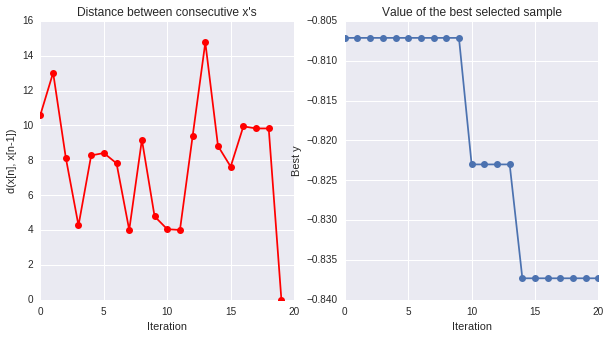

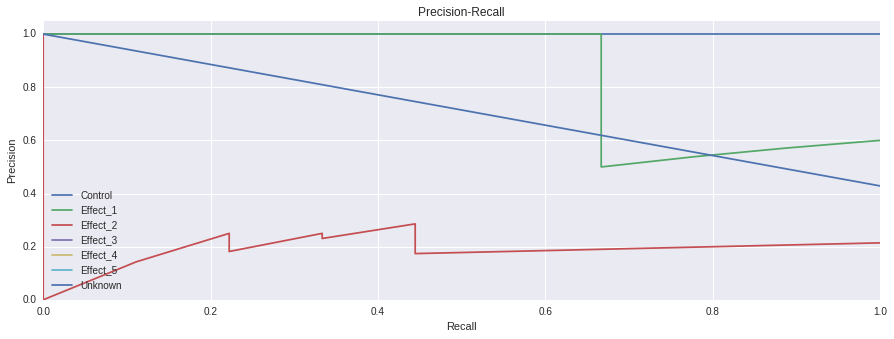

             precision    recall  f1-score   support

    Control       1.00      0.17      0.29         6
   Effect_1       0.86      0.67      0.75         9
   Effect_2       0.00      0.00      0.00         9
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.57      0.67      0.62        18

avg / total       0.57      0.45      0.47        42

0.452380952381
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         1         0         0         0         0         2        3
Effect_1        0         6         0         0         0         0        3
Effect_2        0         0         0         0         6         0        3
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0  

In [7]:
run('rnaseq_all_genes', rnaseq_all_genes, design)

## rnaseq_effector_genes

rnaseq_effector_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


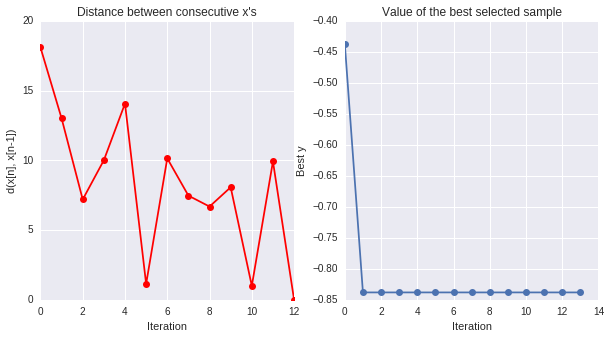

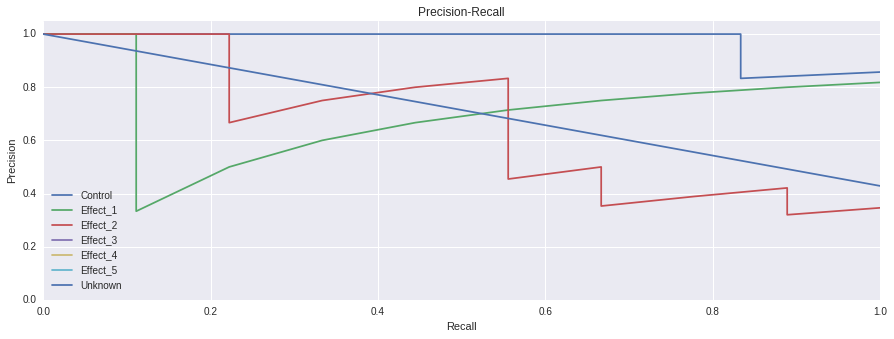

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
    Unknown       0.43      1.00      0.60        18

avg / total       0.18      0.43      0.26        42

0.428571428571
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         0         0        6
Effect_1        0         0         0         0         0         0        9
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0         0         0         0         0         0       18


In [8]:
run('rnaseq_effector_genes', rnaseq_effector_genes, design)

## rnaseq_mod_activities

rnaseq_mod_activities
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


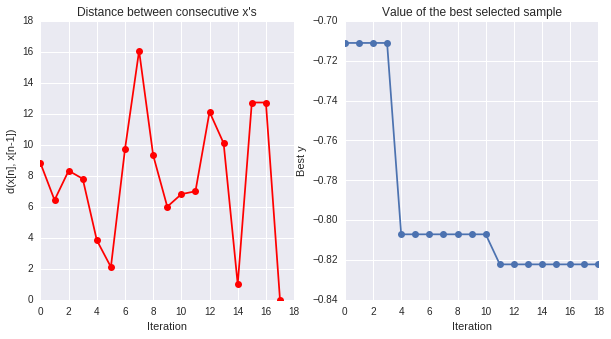

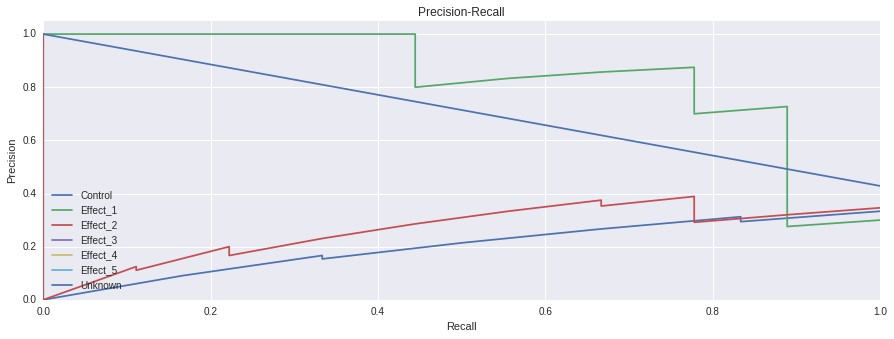

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
    Unknown       0.43      1.00      0.60        18

avg / total       0.18      0.43      0.26        42

0.428571428571
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         0         0        6
Effect_1        0         0         0         0         0         0        9
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0         0         0         0         0         0       18


In [9]:
run('rnaseq_mod_activities', rnaseq_mod_activities, design)

## rnaseq_mod_genevalues

rnaseq_mod_genevalues
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


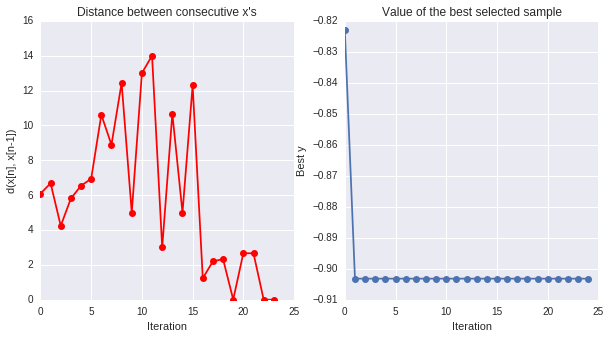

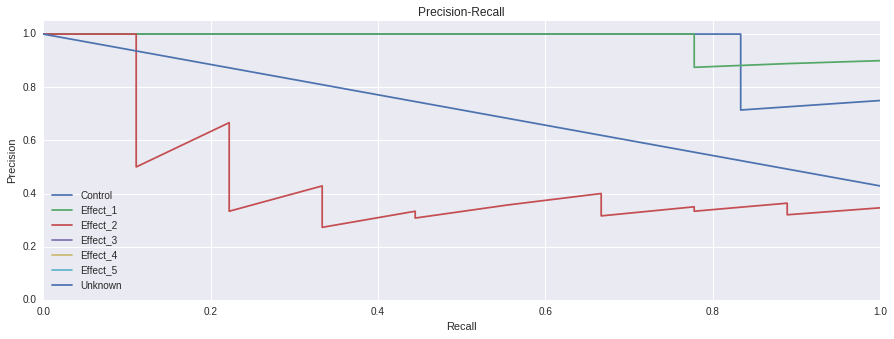

             precision    recall  f1-score   support

    Control       0.71      0.83      0.77         6
   Effect_1       1.00      0.44      0.62         9
   Effect_2       0.40      0.22      0.29         9
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.54      0.72      0.62        18

avg / total       0.63      0.57      0.57        42

0.571428571429
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         5         0         0         0         0         0        1
Effect_1        0         4         0         0         0         0        5
Effect_2        0         0         2         0         2         0        5
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         2         0         3         0         0         0     

In [10]:
run('rnaseq_mod_genevalues', rnaseq_mod_genevalues, design)

## rnaseq_mod_nodevalues

rnaseq_mod_nodevalues
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


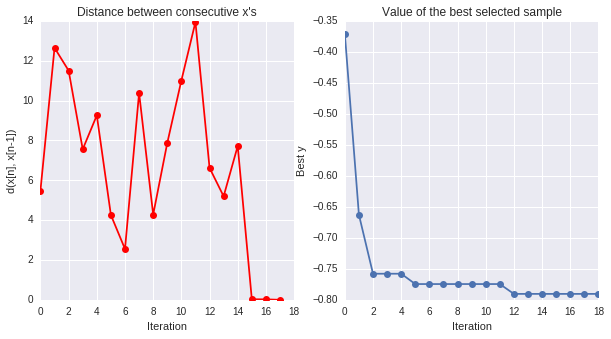

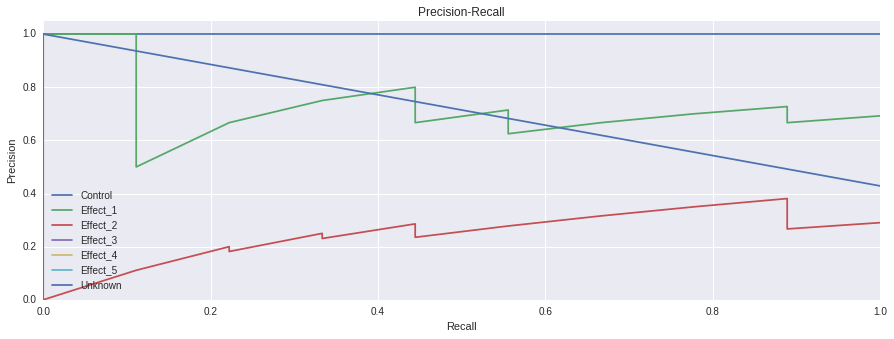

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
    Unknown       0.43      1.00      0.60        18

avg / total       0.18      0.43      0.26        42

0.428571428571
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         0         0        6
Effect_1        0         0         0         0         0         0        9
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0         0         0         0         0         0       18


In [11]:
run('rnaseq_mod_nodevalues', rnaseq_mod_nodevalues, design)

## rnaseq_signaling_genes

rnaseq_signaling_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


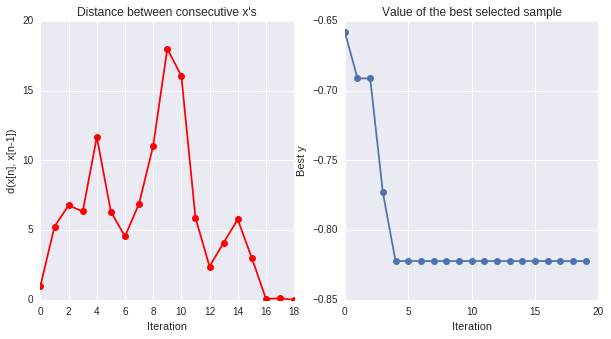

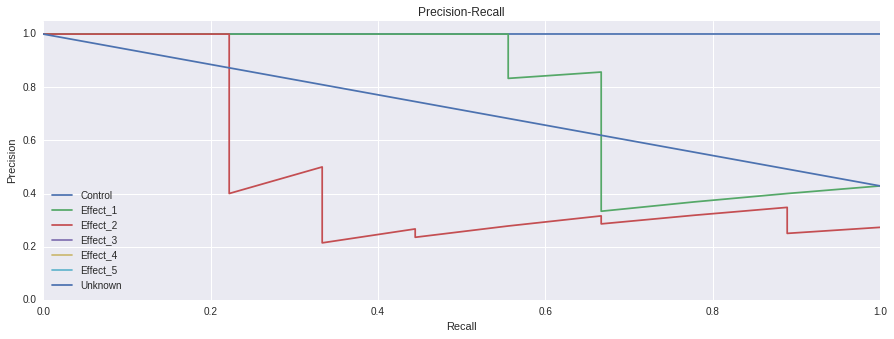

             precision    recall  f1-score   support

    Control       1.00      0.67      0.80         6
   Effect_1       1.00      0.56      0.71         9
   Effect_2       1.00      0.22      0.36         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.63      0.94      0.76        18

avg / total       0.84      0.67      0.67        42

0.666666666667
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         4         0         0         0         0         0        2
Effect_1        0         5         0         0         0         0        4
Effect_2        0         0         2         0         3         0        4
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0  

In [12]:
run('rnaseq_signaling_genes', rnaseq_all_genes, design)

# Microarray Data

In [13]:
%run load_data.py micro

loading microarray data
micro_all_genes: (13613, 105)
micro_effector_genes: (1044, 105)
micro_mod_activities: (89, 105)
micro_mod_genevals: (201, 105)
micro_mod_nodevals: (462, 105)
micro_signaling_genes: (2184, 105)
micro_design: (105, 4)


In [14]:
datasets = [micro_all_genes, micro_effector_genes, micro_mod_activities, micro_mod_genevalues, micro_mod_nodevalues, micro_signaling_genes]
names = ['micro_all_genes', 'micro_effector_genes', 'micro_mod_activities', 'micro_mod_genevals', 'micro_mod_nodevals', 'micro_signaling_genes']
design = micro_design


## micro_all_genes

micro_all_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


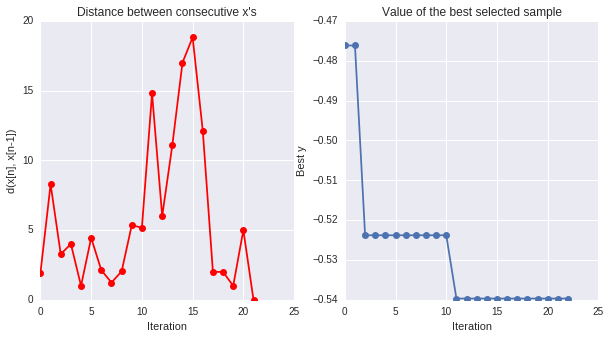

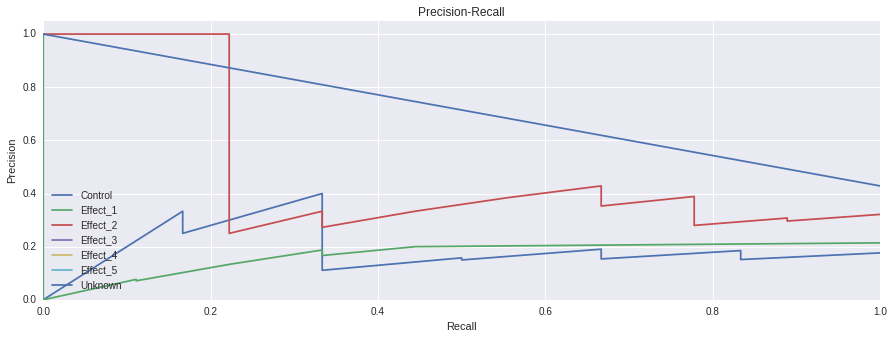

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.41      0.78      0.54        18

avg / total       0.18      0.33      0.23        42

0.333333333333
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         1         0        5
Effect_1        0         0         0         1         2         0        6
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0      

In [15]:
run('micro_all_genes', micro_all_genes, design)

## micro_effector_genes

micro_effector_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


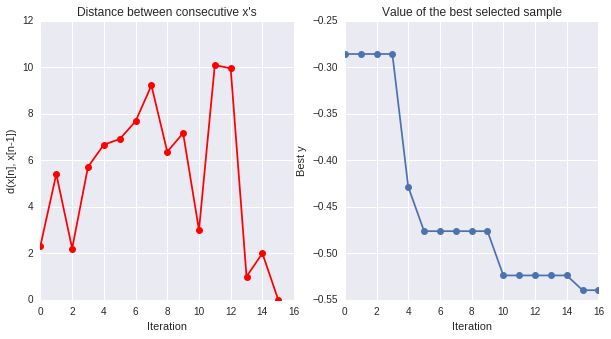

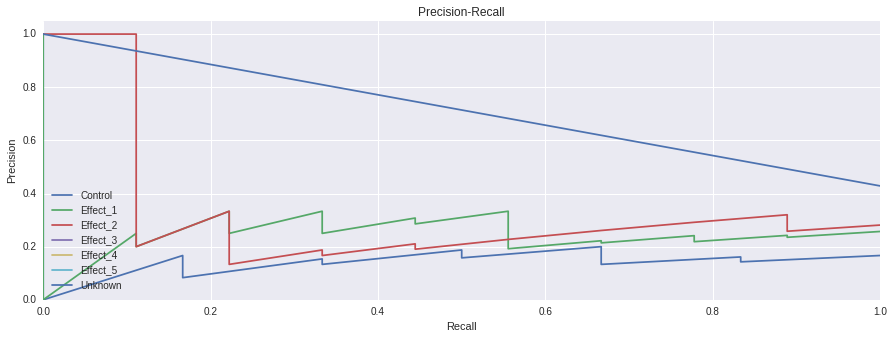

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
    Unknown       0.43      1.00      0.60        18

avg / total       0.18      0.43      0.26        42

0.428571428571
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         0         0        6
Effect_1        0         0         0         0         0         0        9
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0         0         0         0         0         0       18


In [16]:
run('micro_effector_genes', micro_effector_genes, design)

## micro_mod_activities

micro_mod_activities
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


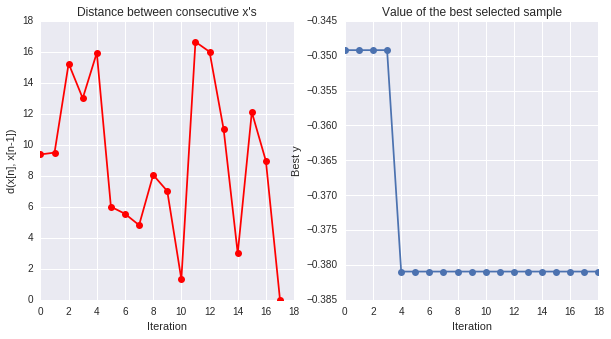

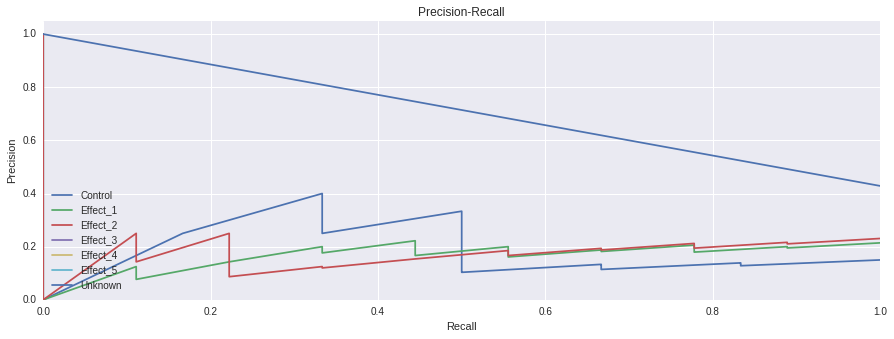

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
    Unknown       0.43      1.00      0.60        18

avg / total       0.18      0.43      0.26        42

0.428571428571
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         0         0         0         0        6
Effect_1        0         0         0         0         0         0        9
Effect_2        0         0         0         0         0         0        9
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         0         0         0         0         0         0       18


In [17]:
run('micro_mod_activities', micro_mod_activities, design)

## micro_mod_genevalues

micro_mod_genevalues
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


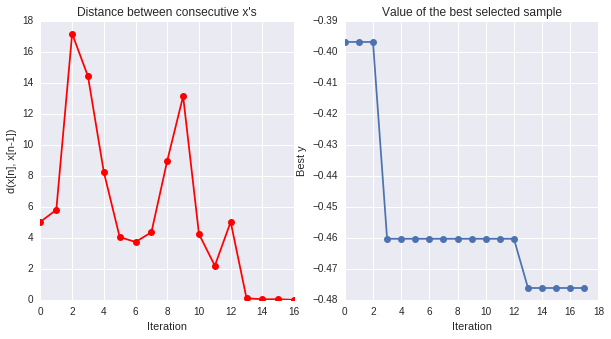

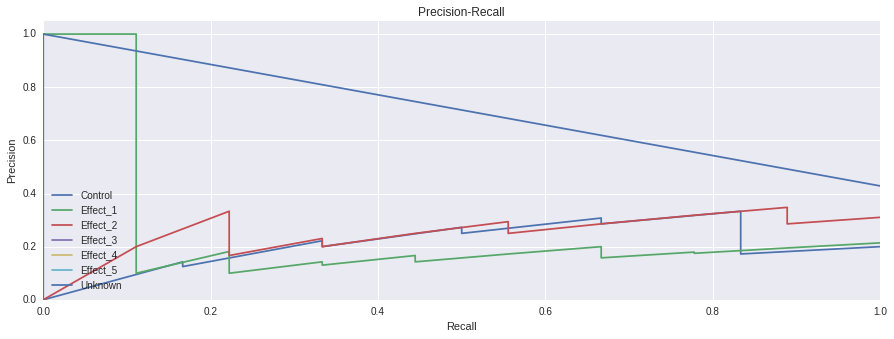

             precision    recall  f1-score   support

    Control       0.00      0.00      0.00         6
   Effect_1       1.00      0.11      0.20         9
   Effect_2       0.00      0.00      0.00         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.33      0.39      0.36        18

avg / total       0.36      0.19      0.20        42

0.190476190476
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         0         0         1         0         0         0        5
Effect_1        1         1         0         0         1         2        4
Effect_2        3         0         0         1         0         0        5
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0      

In [18]:
run('micro_mod_genevalues', micro_mod_genevalues, design)

## micro_mod_nodevalues

micro_mod_nodevalues
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


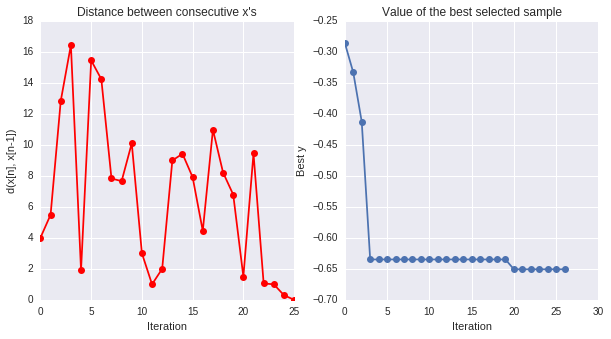

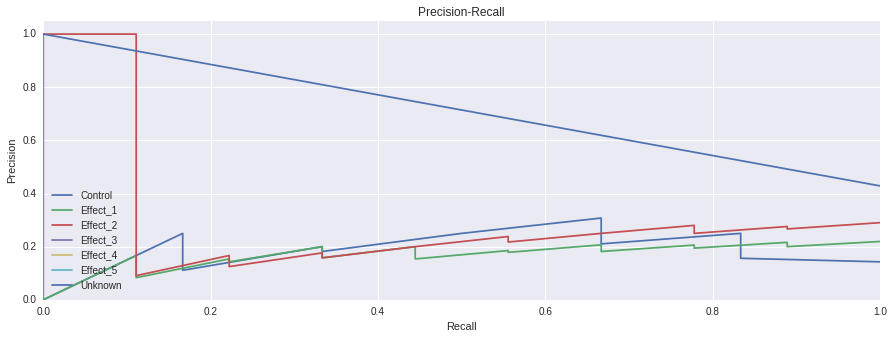

             precision    recall  f1-score   support

    Control       0.11      0.17      0.13         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       1.00      0.11      0.20         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
    Unknown       0.41      0.39      0.40        18

avg / total       0.41      0.21      0.23        42

0.214285714286
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         1         0         0         0         2         0        3
Effect_1        0         0         0         3         1         0        5
Effect_2        5         0         1         1         0         0        2
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0         0         0         0        0
Unknown         3  

In [19]:
run('micro_mod_nodevalues', micro_mod_nodevalues, design)

## micro_signaling_genes

micro_signaling_genes
*Optimization completed.
*Optimization completed.
   -Method converged.
Plot Optimization


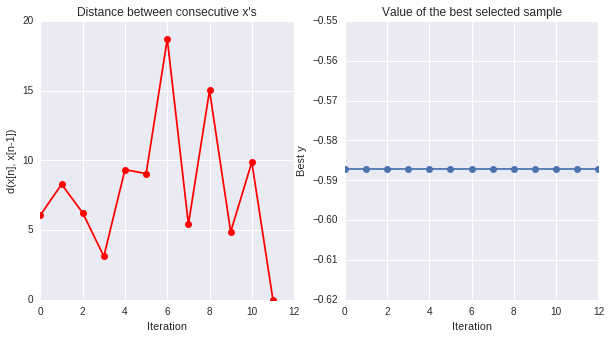

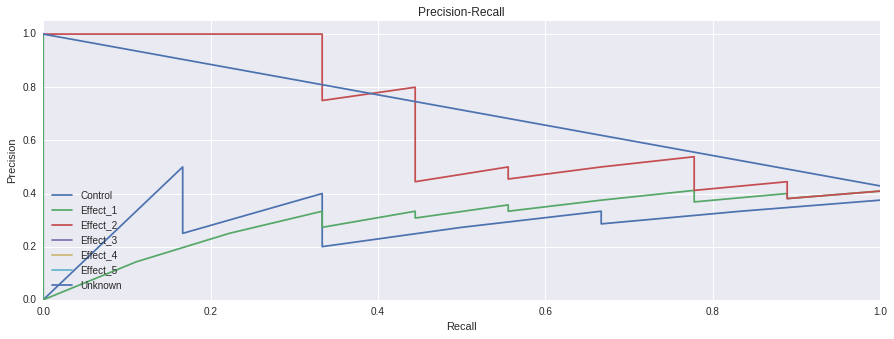

             precision    recall  f1-score   support

    Control       0.40      0.33      0.36         6
   Effect_1       0.00      0.00      0.00         9
   Effect_2       0.00      0.00      0.00         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_5       0.00      0.00      0.00         0
    Unknown       0.36      0.28      0.31        18

avg / total       0.21      0.17      0.19        42

0.166666666667
          Control  Effect_1  Effect_2  Effect_3  Effect_4  Effect_5  Unknown
Control         2         1         0         1         1         0        1
Effect_1        0         0         0         2         0         2        5
Effect_2        3         1         0         2         0         0        3
Effect_3        0         0         0         0         0         0        0
Effect_4        0         0         0         0         0         0        0
Effect_5        0         0         0      

In [20]:
run('micro_signaling_genes', micro_all_genes, design)